In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pathlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-13 05:57:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  23.0MB/s    in 3.8s    

2023-06-13 05:57:52 (21.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Set the path to the image dataset folder
dataset_path = '/content/drive/MyDrive/cotton/train'



In [ ]:
# Define the class labels
class_labels = ['Target spot', 'Powdery Mildew', 'Healthy', 'Bacterial Blight', 'Army worm']
num_classes = len(class_labels)


# Data preprocessing
data = []
labels = []
for i, class_label in enumerate(class_labels):
    class_folder_path = os.path.join(dataset_path, class_label)
    for image_name in os.listdir(class_folder_path):
        image_path = os.path.join(class_folder_path, image_name)
        image = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        image_array = keras.preprocessing.image.img_to_array(image)
        data.append(image_array)
        labels.append(i)



In [ ]:
# Convert the data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape= (224,224,3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [ ]:
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(5, activation='softmax')(x)


#Append the dense network to the base model
model = Model( pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Normalize the image data
data = data / 255.0

# Split the dataset into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)


In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
train_datagen.fit(train_data)

In [ ]:
history = model.fit(train_datagen.flow(train_data, train_labels, batch_size=128),
                    steps_per_epoch=len(train_data) // 128,
                    epochs=50,
                    validation_data=(val_data, val_labels))

Epoch 1/50
12/12 [==============================] - 41s 2s/step - loss: 6.0699 - accuracy: 0.3064 - val_loss: 0.7007 - val_accuracy: 0.7350
Epoch 2/50
12/12 [==============================] - 20s 2s/step - loss: 1.0316 - accuracy: 0.6909 - val_loss: 0.3934 - val_accuracy: 0.8675
Epoch 3/50
12/12 [==============================] - 18s 2s/step - loss: 0.3732 - accuracy: 0.8682 - val_loss: 0.2447 - val_accuracy: 0.9150
Epoch 4/50
12/12 [==============================] - 21s 2s/step - loss: 0.2222 - accuracy: 0.9258 - val_loss: 0.1863 - val_accuracy: 0.9375
Epoch 5/50
12/12 [==============================] - 26s 2s/step - loss: 0.1766 - accuracy: 0.9416 - val_loss: 0.1675 - val_accuracy: 0.9500
Epoch 6/50
12/12 [==============================] - 20s 2s/step - loss: 0.1450 - accuracy: 0.9552 - val_loss: 0.1126 - val_accuracy: 0.9650
Epoch 7/50
12/12 [==============================] - 21s 2s/step - loss: 0.1232 - accuracy: 0.9545 - val_loss: 0.0935 - val_accuracy: 0.9675
Epoch 8/50
12/12 [==

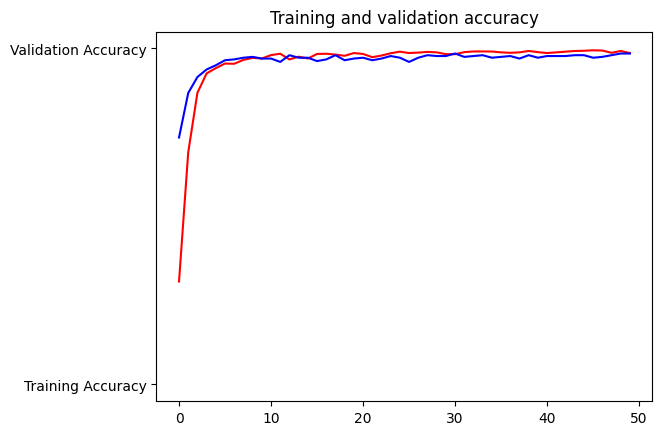

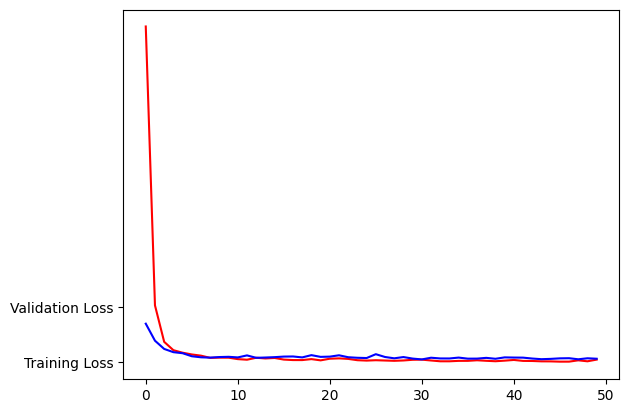

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

['MILDEW1.jpg', 'MILDEW2.jpg', 'MILDEW3.jpg', 'SPOT1.jpg', 'SPOT2.png', 'SPOT3.jpg', 'BLIGHTCOT1.jpg', 'BLIGHTCOT3.jpg', 'WORM1.jpg', 'WORM2.jpg', 'WORM4.jpg', 'HEALTHYCOT1.jpg', 'HEALTHYCOT2.jpg', 'HEALTHYCOT3.jpg', 'BLIGHT6.jpeg']

1/1 [==============================] - 0s 25ms/step


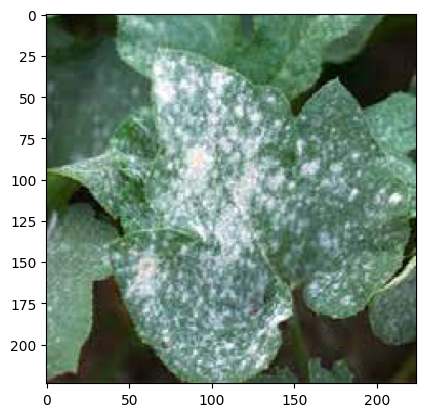

Predicted Label: Powdery Mildew
/content/drive/MyDrive/test_cotton/MILDEW1.jpg
Prediction Scores: [[3.8717411e-19 1.0000000e+00 1.3402148e-18 2.3666035e-19 2.0298771e-19]]

1/1 [==============================] - 0s 27ms/step


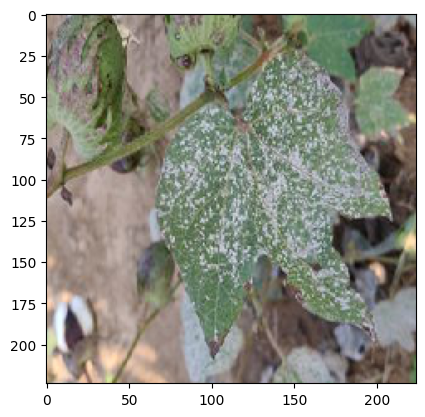

Predicted Label: Powdery Mildew
/content/drive/MyDrive/test_cotton/MILDEW2.jpg
Prediction Scores: [[7.2325271e-08 9.9972028e-01 7.6454988e-08 2.1374704e-04 6.5742883e-05]]

1/1 [==============================] - 0s 24ms/step


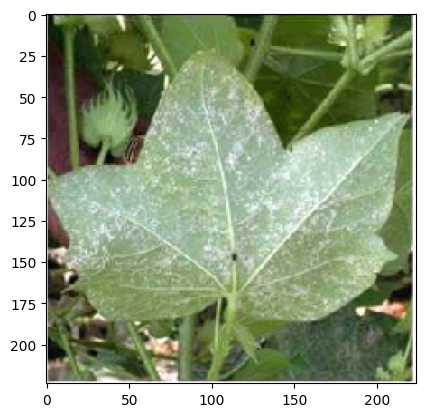

Predicted Label: Powdery Mildew
/content/drive/MyDrive/test_cotton/MILDEW3.jpg
Prediction Scores: [[4.0259154e-10 1.0000000e+00 6.9781775e-10 2.1640003e-09 8.8671775e-10]]

1/1 [==============================] - 0s 24ms/step


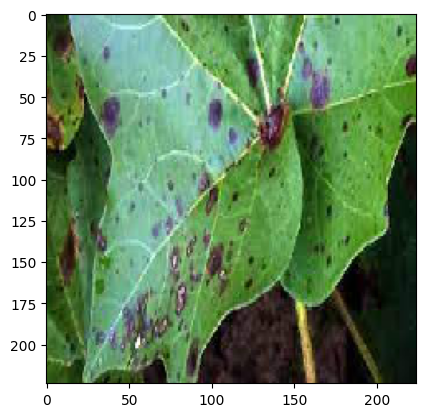

Predicted Label: Target spot
/content/drive/MyDrive/test_cotton/SPOT1.jpg
Prediction Scores: [[9.9999893e-01 8.1053403e-10 3.3562958e-10 1.0454830e-06 1.7226342e-11]]

1/1 [==============================] - 0s 26ms/step


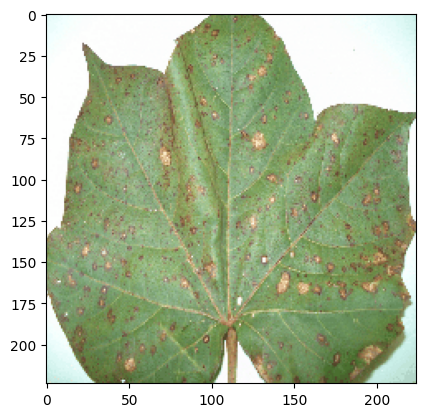

Predicted Label: Target spot
/content/drive/MyDrive/test_cotton/SPOT2.png
Prediction Scores: [[9.9999845e-01 9.7113748e-09 6.9900667e-09 1.5665408e-06 2.4179872e-10]]

1/1 [==============================] - 0s 45ms/step


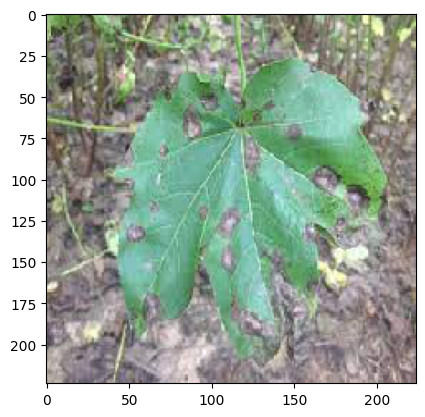

Predicted Label: Target spot
/content/drive/MyDrive/test_cotton/SPOT3.jpg
Prediction Scores: [[9.9974781e-01 1.3675965e-07 2.2859182e-05 2.2815916e-04 1.0612066e-06]]

1/1 [==============================] - 0s 30ms/step


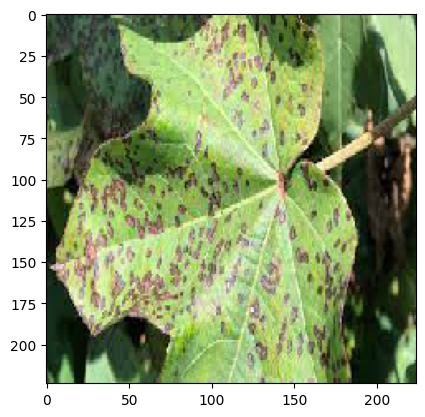

Predicted Label: Bacterial Blight
/content/drive/MyDrive/test_cotton/BLIGHTCOT1.jpg
Prediction Scores: [[1.16258474e-04 3.89772140e-06 2.22697531e-06 9.99877572e-01
  5.08061504e-08]]

1/1 [==============================] - 0s 27ms/step


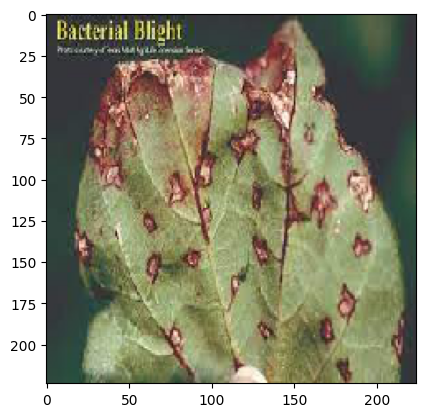

Predicted Label: Bacterial Blight
/content/drive/MyDrive/test_cotton/BLIGHTCOT3.jpg
Prediction Scores: [[9.2814364e-02 2.1980920e-06 7.0085338e-07 9.0718204e-01 7.1369431e-07]]

1/1 [==============================] - 0s 34ms/step


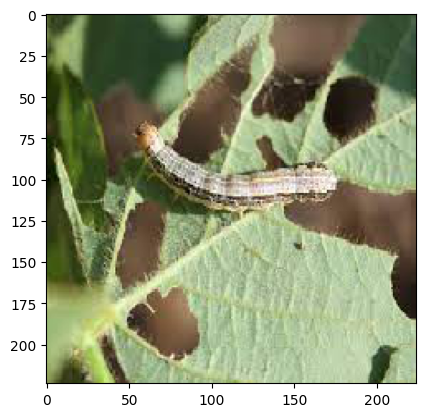

Predicted Label: Army worm
/content/drive/MyDrive/test_cotton/WORM1.jpg
Prediction Scores: [[1.1508788e-15 1.2803461e-13 1.9771661e-13 3.1575382e-13 1.0000000e+00]]

1/1 [==============================] - 0s 28ms/step


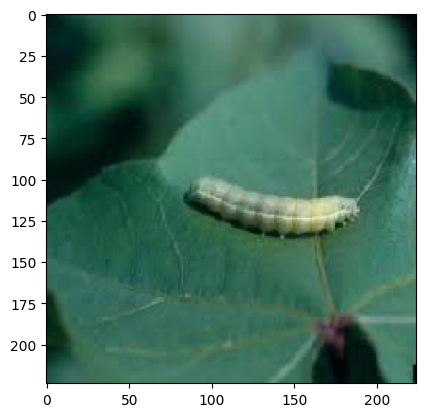

Predicted Label: Army worm
/content/drive/MyDrive/test_cotton/WORM2.jpg
Prediction Scores: [[1.3563894e-12 5.0423381e-12 3.0926092e-11 8.7688700e-14 1.0000000e+00]]

1/1 [==============================] - 0s 26ms/step


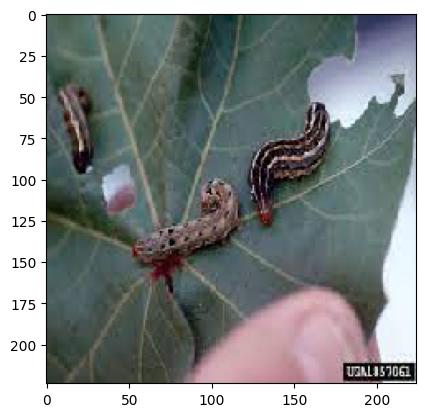

Predicted Label: Army worm
/content/drive/MyDrive/test_cotton/WORM4.jpg
Prediction Scores: [[1.4829366e-09 2.2992158e-08 6.7913186e-07 1.1857142e-10 9.9999928e-01]]

1/1 [==============================] - 0s 30ms/step


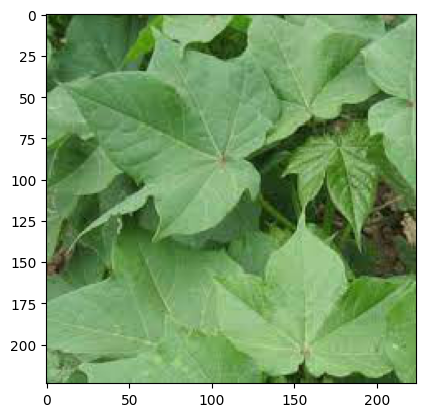

Predicted Label: Healthy
/content/drive/MyDrive/test_cotton/HEALTHYCOT1.jpg
Prediction Scores: [[2.9963125e-05 3.3450756e-06 9.9995184e-01 1.0807824e-05 4.0926684e-06]]

1/1 [==============================] - 0s 32ms/step


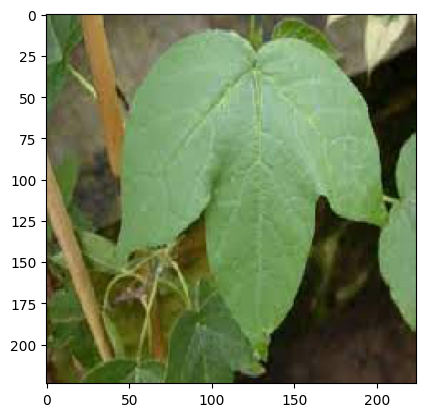

Predicted Label: Healthy
/content/drive/MyDrive/test_cotton/HEALTHYCOT2.jpg
Prediction Scores: [[0.02172308 0.02340786 0.54275495 0.15338013 0.25873402]]

1/1 [==============================] - 0s 39ms/step


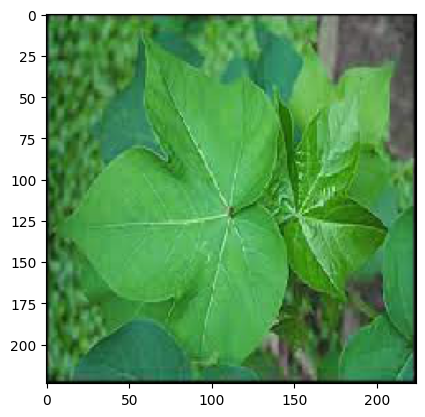

Predicted Label: Healthy
/content/drive/MyDrive/test_cotton/HEALTHYCOT3.jpg
Prediction Scores: [[2.8185443e-06 2.1064902e-07 9.9998772e-01 7.4228724e-06 1.9308379e-06]]

1/1 [==============================] - 0s 26ms/step


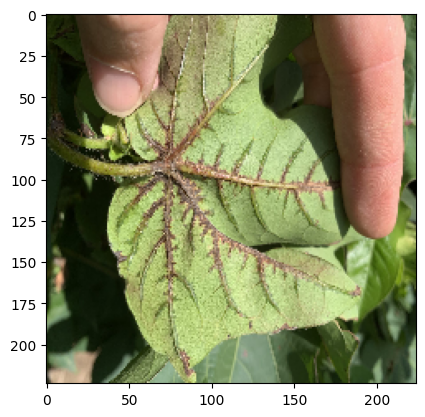

Predicted Label: Bacterial Blight
/content/drive/MyDrive/test_cotton/BLIGHT6.jpeg
Prediction Scores: [[1.9840065e-06 4.0639581e-08 5.1950440e-07 9.9999690e-01 5.6310199e-07]]


In [ ]:
 # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os
import matplotlib.pyplot as plt

images = os.listdir("/content/drive/MyDrive/test_cotton")

print(images)

for i in images:
  print()
 # predicting images
  path = '/content/drive/MyDrive/test_cotton/' + i
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = loaded_model.predict(images, batch_size=10)
  pred = np.argmax(classes, axis=-1)
  predicted_label = class_labels[pred[0]]

  plt.imshow(img)
  plt.show()
  print("Predicted Label:", predicted_label)
  print(path)
  print("Prediction Scores:", classes)


Saving BLIGHT6.jpeg to BLIGHT6.jpeg
1/1 [==============================] - 0s 28ms/step


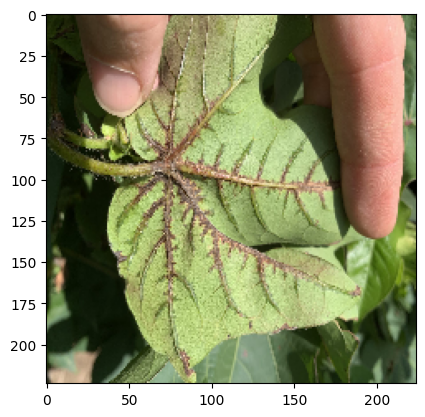

Predicted Label: Bacterial Blight
/content/BLIGHT6.jpeg
Prediction Scores: [[3.6706581e-08 2.2612949e-10 3.4715228e-10 1.0000000e+00 6.3497657e-10]]


In [ ]:
 # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os
from google.colab import files

uploaded=files.upload()


for i in uploaded.keys():

 # predicting images
  path = '/content/' + i
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  pred = np.argmax(classes, axis=-1)
  predicted_label = class_labels[pred[0]]

  plt.imshow(img)
  plt.show()
  print("Predicted Label:", predicted_label)
  print(path)
  print("Prediction Scores:", classes)


In [ ]:
# Save model weights and architecture
model.save_weights('/content/drive/MyDrive/modelcotton1_weights.h5')
model.save('/content/drive/MyDrive/modelcotton1_saved.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Load model architectur
loaded_model = load_model('/content/drive/MyDrive/modelcotton1_saved.h5')

# Load model weights
loaded_model.load_weights('/content/drive/MyDrive/modelcotton1_weights.h5')


In [ ]:
!pip install tensorflow_model_optimization
from tensorflow_model_optimization.sparsity import keras as sparsity

prune_low_magnitude = sparsity.prune_low_magnitude
pruned_model = prune_low_magnitude(model)
pruned_model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 71.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


In [ ]:
export = '/content/drive/MyDrive/saved_model_cotton'
#tf.saved_model.save(model, export)

In [ ]:
# Select mode of optimization
mode = "Storage"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_ops = 1000000
converter.experimental_new_converter = True
converter.experimental_new_converter_num_threads = 1
tflite_model = converter.convert();


In [ ]:
tflite_model_file = pathlib.Path('./Cotton_Predict.tflite')
tflite_model_file.write_bytes(tflite_model)

131748628

In [ ]:
prediction = loaded_model.predict()

TypeError: ignored

In [ ]:
x = list(range(10,1,-1))
print(x)